## Running Lasso and Logistic regression into the compressed embeddings

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pickle
from scipy.stats import spearmanr

from sklearn import metrics

import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

## Data Loaders 

In [7]:
def load_data(dataset_name, compression_methd):

    if dataset_name == 'beta_lactamase':
        target_name = 'scaled_effect1'
    elif dataset_name == 'fluorescence':
        target_name = 'log_fluorescence'
    elif dataset_name == 'subcellular_localization' or dataset_name == 'subcellular_localization_2':
        target_name = 'localization'
    elif dataset_name == 'solubility':
        target_name = 'solubility'
    elif dataset_name == 'stability':
        target_name = 'stability_score'


    ## train
    metadata_train = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_train_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks_esm2_150M/{dataset_name}_train_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    train = pd.merge(metadata_train,embed, on='ID')
    y_train = train[target_name].values
    X_train = train.iloc[:, metadata_train.shape[1]:].values
   
    ## test
    metadata_test = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_test_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks_esm2_150M/{dataset_name}_test_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    test = pd.merge(metadata_test,embed, on='ID')
    y_test = test[target_name].values
    X_test = test.iloc[:, metadata_test.shape[1]:].values


    ## val
    metadata_valid = pd.read_csv(f'data/benchmarks/{dataset_name}/{dataset_name}_valid_metadata.csv')
    embed = pd.read_pickle(f'embeddings/embeddings_benchmarks_esm2_150M/{dataset_name}_valid_esm2_150M_compressed/embed_layer_30_{compression_methd}.pkl')
    embed = pd.DataFrame.from_dict(embed, orient='index').reset_index()
    embed.rename(columns={'index':'ID'}, inplace=True)
    val = pd.merge(metadata_valid, embed, on='ID')
    y_val = val[target_name].values
    X_val = val.iloc[:, metadata_valid.shape[1]:].values

    print('Dataset statistics')
    print(f"Train --> X:{X_train.shape}, y:{y_train.shape}\nVal  --> X:{X_val.shape}, y:{y_val.shape}\nTest --> X:{X_test.shape}, y:{y_test.shape}")
    
    
    # Check if CUDA is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Convert them to PyTorch tensors and send them to the chosen device
    X_train, y_train = torch.from_numpy(X_train).float().to(device), torch.from_numpy(y_train).float().to(device)
    X_val, y_val = torch.from_numpy(X_val).float().to(device), torch.from_numpy(y_val).float().to(device)
    X_test, y_test = torch.from_numpy(X_test).float().to(device), torch.from_numpy(y_test).float().to(device)


    # Create TensorDatasets
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    test_dataset = TensorDataset(X_test, y_test)


    # Create DataLoaders
    batch_size = 64
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

In [8]:
train_loader, val_loader, test_loader = load_data('beta_lactamase', 'iDCT')

Dataset statistics
Train --> X:(4158, 5120), y:(4158,)
Val  --> X:(520, 5120), y:(520,)
Test --> X:(520, 5120), y:(520,)
Using device: cuda


In [9]:
# Define the model
class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.layer1 = nn.Linear(input_size, input_size//8)
        self.layer2 = nn.Linear(input_size//8, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        return x

model = RegressionNet(5120)
model.to('cuda')

RegressionNet(
  (layer1): Linear(in_features=5120, out_features=640, bias=True)
  (layer2): Linear(in_features=640, out_features=1, bias=True)
  (relu): ReLU()
)

In [14]:
from sklearn.metrics import r2_score
from scipy.stats import spearmanr

def evaluate_model(model, loader, dataset_name="Validation"):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            # Collect all predictions and actual targets
            predictions.append(outputs)
            actuals.append(targets.view(-1, 1))
    
    # Convert lists of batches into a single tensor
    predictions = torch.cat(predictions).cpu().numpy()
    actuals = torch.cat(actuals).cpu().numpy()
    
    # Calculate R^2 score
    r2 = r2_score(actuals, predictions)
    print(f'{dataset_name} set R^2: {r2:.4f}')

    # Calculate Spearman's rank correlation
    corr, _ = spearmanr(actuals, predictions)
    print(f'{dataset_name} set Rho: {corr:.4f}')

In [7]:
def train_model(model, train_loader, num_epochs, learn_rate):
    # Loss and Optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    # Initialize a single progress bar for all epochs
    pbar = tqdm(total=num_epochs, desc='Training Progress', unit='epoch')
    model.train()
    for epoch in range(num_epochs):
        epoch_loss = 0
        for inputs, targets in train_loader:
            # Move data to the correct device
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets.view(-1, 1))
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Accumulate the loss over the epoch
            epoch_loss += loss.item()
        # Update the progress bar with the average loss for the current epoch
        pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
        pbar.set_postfix(avg_loss=epoch_loss / len(train_loader))
        pbar.update(1)  # Move the progress bar forward for one epoch
    pbar.close()

In [8]:
lr_values = [1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2]

for lr in lr_values: 

    print(f"Training model with learning rate: {lr}")
    model = RegressionNet(5120)
    model.to('cuda')
    epochs = 100
    train_model(model, train_loader, epochs, lr)
    evaluate_model(model, train_loader, "train")
    evaluate_model(model, val_loader, "Validation")
    evaluate_model(model, test_loader, "Test")
    print()

Training model with learning rate: 1e-05


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.04epoch/s, avg_loss=0.0676]


train set R^2: 0.3271
train set Rho: 0.6734
Validation set R^2: 0.2823
Validation set Rho: 0.6340
Test set R^2: 0.2796
Test set Rho: 0.6107

Training model with learning rate: 2e-05


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.32epoch/s, avg_loss=0.0567]


train set R^2: 0.4495
train set Rho: 0.7125
Validation set R^2: 0.3960
Validation set Rho: 0.6663
Test set R^2: 0.3907
Test set Rho: 0.6530

Training model with learning rate: 5e-05


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.08epoch/s, avg_loss=0.0521]


train set R^2: 0.5331
train set Rho: 0.7429
Validation set R^2: 0.4762
Validation set Rho: 0.6952
Test set R^2: 0.4667
Test set Rho: 0.6888

Training model with learning rate: 0.0001


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 16.95epoch/s, avg_loss=0.0504]


train set R^2: 0.5403
train set Rho: 0.7515
Validation set R^2: 0.4869
Validation set Rho: 0.7028
Test set R^2: 0.4719
Test set Rho: 0.7007

Training model with learning rate: 0.0002


Epoch 100/100: 100%|██████████| 100/100 [00:06<00:00, 16.01epoch/s, avg_loss=0.0596]


train set R^2: 0.4008
train set Rho: 0.7421
Validation set R^2: 0.3407
Validation set Rho: 0.6929
Test set R^2: 0.3489
Test set Rho: 0.6901

Training model with learning rate: 0.0005


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 16.86epoch/s, avg_loss=0.0563]


train set R^2: 0.3931
train set Rho: 0.6907
Validation set R^2: 0.3414
Validation set Rho: 0.6467
Test set R^2: 0.3426
Test set Rho: 0.6305

Training model with learning rate: 0.001


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 16.97epoch/s, avg_loss=0.0548]


train set R^2: 0.4206
train set Rho: 0.7345
Validation set R^2: 0.3603
Validation set Rho: 0.6826
Test set R^2: 0.3663
Test set Rho: 0.6793

Training model with learning rate: 0.002


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 16.97epoch/s, avg_loss=0.049]


train set R^2: 0.5400
train set Rho: 0.7527
Validation set R^2: 0.4836
Validation set Rho: 0.7030
Test set R^2: 0.4660
Test set Rho: 0.7010

Training model with learning rate: 0.005


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.02epoch/s, avg_loss=0.045]


train set R^2: 0.4336
train set Rho: 0.7682
Validation set R^2: 0.3697
Validation set Rho: 0.7197
Test set R^2: 0.3704
Test set Rho: 0.7203

Training model with learning rate: 0.01


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.17epoch/s, avg_loss=0.0556]


train set R^2: 0.5737
train set Rho: 0.7688
Validation set R^2: 0.5131
Validation set Rho: 0.7213
Test set R^2: 0.5057
Test set Rho: 0.7230

Training model with learning rate: 0.02


Epoch 100/100: 100%|██████████| 100/100 [00:05<00:00, 17.33epoch/s, avg_loss=0.1]
/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


train set R^2: -0.0000
train set Rho: nan
Validation set R^2: -0.0034
Validation set Rho: nan
Test set R^2: 0.0000
Test set Rho: nan



/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/stor/work/Wilke/luiz/DMS_iDCT/venv/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


## Trainer

In [10]:
class Trainer():
    def __init__(self, model, train_loader, val_loader, test_loader, learn_rate):
        self.model = model
        self.learn_rate = learn_rate
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.history = {'train_loss': [], 'val_loss': []}
        self.best_model = None
    
    def train(self):
        loss_fct = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learn_rate)
        model.train()
        train_losses = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            # Forward pass
            outputs = model(inputs)
            loss = loss_fct(outputs, targets.view(-1, 1))
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        train_avg_loss = np.mean(train_losses)
        return train_avg_loss
        
    def eval(self):
        loss_fct = nn.MSELoss()
        model.eval()
        eval_losses = []

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = loss_fct(outputs, targets.view(-1, 1))
                eval_losses.append(loss.item())
        eval_avg_loss = np.mean(eval_losses)
        return eval_avg_loss
        
    
    def run(self, num_epochs):
        Best_val_loss = float('inf')
        best_model_state = None 
        best_epoch = 0
        pbar = tqdm(total=num_epochs, desc='Training Progress', unit='epoch')
        
        for epoch in range(num_epochs):
            train_loss = self.train()
            eval_loss = self.eval()
            
            if eval_loss < Best_val_loss:
                Best_val_loss = eval_loss
                best_model_state = self.model.state_dict()
                best_epoch = epoch + 1

            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(eval_loss)
            
            # Update the progress bar with the average loss for the current epoch
            pbar.set_description(f'Epoch {epoch+1}/{num_epochs}')
            pbar.set_postfix(train_loss=train_loss, val_loss=eval_loss)
            pbar.update(1)
        pbar.close()  

        if best_model_state is not None:
            self.model.load_state_dict(best_model_state)
            print(f"Best model loaded from epoch {best_epoch} with validation loss of {Best_val_loss:.4f}")

        return self.model, self.history

In [10]:
model = RegressionNet(5120)
model.to('cuda')

trainer = Trainer(model, train_loader, val_loader, test_loader, 0.001)
model, history = trainer.run(1000)

Epoch 2/1000:   0%|          | 2/1000 [00:00<01:01, 16.19epoch/s, train_loss=0.103, val_loss=0.106]

Epoch 1000/1000: 100%|██████████| 1000/1000 [01:02<00:00, 16.03epoch/s, train_loss=0.0441, val_loss=0.0419]

Best model loaded from epoch 989 with validation loss of 0.0410


In [38]:
evaluate_model(model, test_loader, "Test")

Test set R^2: 0.3781
Test set Rho: 0.6514


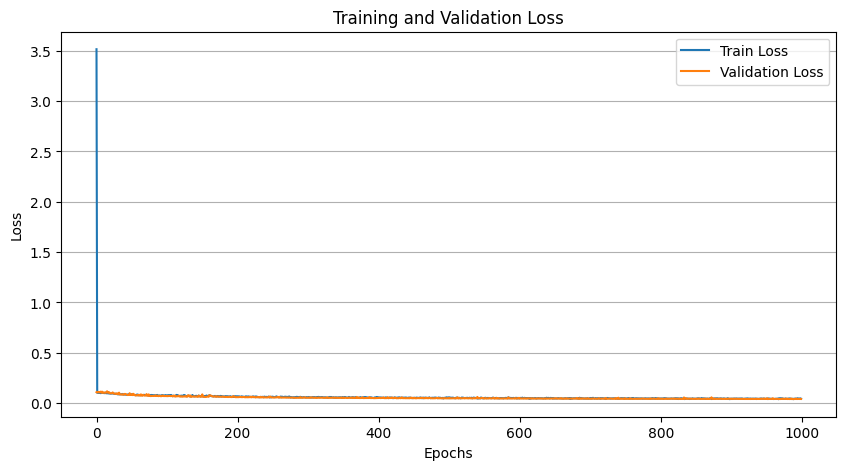

In [12]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(axis='y')
plt.show()

## Fluorescence

In [11]:
train_loader, val_loader, test_loader = load_data('fluorescence', 'iDCT')

Dataset statistics
Train --> X:(21446, 5120), y:(21446,)
Val  --> X:(5362, 5120), y:(5362,)
Test --> X:(27217, 5120), y:(27217,)
Using device: cuda


In [39]:
model = RegressionNet(5120)
model.to('cuda')

trainer = Trainer(model, train_loader, val_loader, test_loader, 0.005)
model, history = trainer.run(100)

Training Progress:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 100/100: 100%|██████████| 100/100 [00:56<00:00,  1.76epoch/s, train_loss=0.196, val_loss=0.215]

Best model loaded from epoch 98 with validation loss of 0.1519


In [40]:
evaluate_model(model, test_loader, "Test")

Test set R^2: 0.4099
Test set Rho: 0.6603


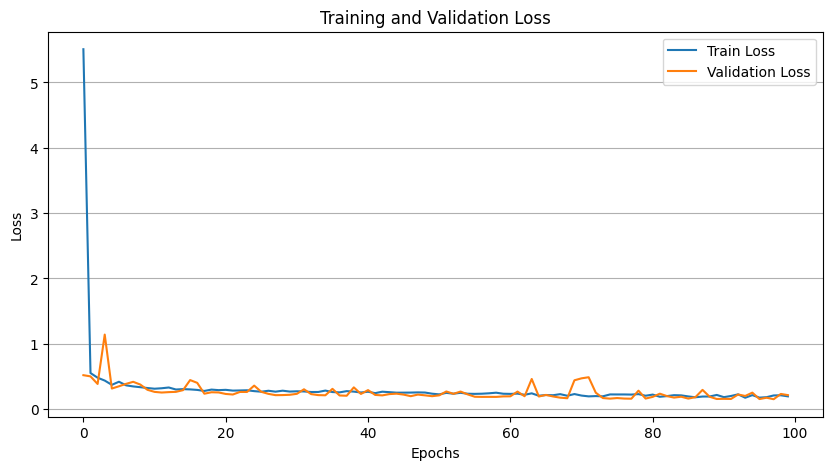

In [41]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(axis='y')
plt.show()

# Results
## IDCT
Average Validation Loss: 0.0292

Validation set R^2: 0.7014
Test set R^2: 0.6625

Validation set Spearman correlation: 0.8471
Test set Spearman correlation: 0.8519

## Mean
Average Validation Loss: 0.0344

Validation set R^2: 0.6700
Test set R^2: 0.6649

Validation set Spearman correlation: 0.7620
Test set Spearman correlation: 0.7593